## Corona Virus Ecuador

**Lenin G. Falconi**

**Marzo 20, 2020**

Para los cálculos presentados a continuación se considera como base:

https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

### Navegación por la presentación:
* Para ir hacia adelante: barra espaciadora
* Para retornar: shift + barra espaciadora

### Data
La data utilizada es la proporcionada por la posta en una gráfica publicada con datos hasta 18 marzo.

### Objetivos:
* Aproximar un modelo de regresión logística para el comportamiento de contagio sin control en Ecuador
* Aproximar modelos de otros países. Para interpolar a los datos locales. (Pendiente)
* Corregir los cálculos del primer objetivo considerando el factor movilidad (Pendiente)

### Objetivos:
* Modelar considerando cómo el número de hospitales, número de respiradores, número de población con movilidad restringida? Para un enfoque de aprendizaje supervisado se require de datos para esta etapa. 


In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

### Data
Organizo los datos del gráfico de **La Posta** en un archivo csv

In [2]:
os.listdir()

['rise.css',
 'CoronaVirusEcu.ipynb',
 '.gitignore',
 'environment.yml',
 'coronavirusEcu.csv',
 '.ipynb_checkpoints',
 'README.md',
 'images',
 '.git',
 'coronavirusEcu_formatted.csv']

In [3]:
df = pd.read_csv('coronavirusEcu.csv')
df


,Date,Number_of_Cases
0,2020-02-28,0
1,2020-02-29,1
2,2020-03-01,6
3,2020-03-02,7
4,2020-03-04,10
5,2020-03-05,13
6,2020-03-06,14
7,2020-03-08,15
8,2020-03-10,17
9,2020-03-12,19


Se obtiene el gráfico original de los datos proveídos

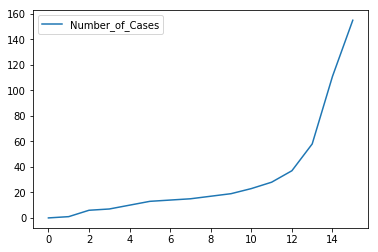

In [4]:
df.plot.line()


En forma similar a la referencia seguida en esta presentación, se convierte las fechas a números considerando al 1 de enero de 2020 como día 1 del año. Esto se podría replantear considerando más bien al inicio de la infección como el día 1. Posiblemente, por facilidad el autor original ha considerado usar este presupuesto para calcular el día de climax de infección.

In [5]:
FMT = '%Y-%m-%d'
date = df['Date']
df['Date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )
df

,Date,Number_of_Cases
0,58,0
1,59,1
2,60,6
3,61,7
4,63,10
5,64,13
6,65,14
7,67,15
8,69,17
9,71,19


Esta nueva tabla de valores se guarda en un nuevo csv para facilidad de uso y verificar los cálculos en otras herramientas como *Matlab*

In [6]:
df.to_csv('coronavirusEcu_formatted.csv')

Extracción de los datos en variables $x$ y  $y$, para modelar una ecuación paramétrica del tipo $y=f(x)$

In [7]:
y = np.array(df['Number_of_Cases'].values.tolist())
y

array([  0,   1,   6,   7,  10,  13,  14,  15,  17,  19,  23,  28,  37,
        58, 111, 155])

In [8]:
# x = np.array(df.index.tolist())
# x = df.index.tolist()
x = np.array(df['Date'])
x

array([58, 59, 60, 61, 63, 64, 65, 67, 69, 71, 72, 73, 74, 75, 76, 77])

Se define el modelo logístico de acuerdo a la ecuación presentada en la publicación original. No obstante, ésta puede ser reformulada y debería considerar factores atenuantes. La ecuación es:

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

Donde:
* $y$: número de contagiados o casos totales
* $x$: día del año para el que se tiene un valor determinado de contagiados
* $a$: velocidad de infección.
* $b$: día en el que ocurre el máximo de infecciones
* $c$: total de infectados en la población.

In [9]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

Ajuste de curva considerando valores iniciales indicados.

In [10]:
popt, pcov = curve_fit(logistic_model,x,y, p0=[10, 80, 2e4],  method='lm', maxfev=4000)
popt

array([2.45057581e+00, 1.05233526e+02, 1.55915121e+07])

In [11]:
(a_, b_, c_) = popt

Matriz Covariante

In [12]:
np.diag(pcov)

array([6.07977997e-01, 1.98254645e+10, 7.98377306e+23])

Error standard para cada parámetro:

In [13]:
np.sqrt(np.diag(pcov))

array([7.79729438e-01, 1.40802928e+05, 8.93519617e+11])

El error del parámetro $c$ es muy elevado:

In [14]:
errors_values = np.sqrt(np.diag(pcov))
errors_variables = ["a_err", "b_err", "c_err"]
errors_dict = dict(zip(errors_variables, errors_values))
errors_dict

{'a_err': 0.77972943814088,
 'b_err': 140802.9278413902,
 'c_err': 893519617061.2937}

Para los mismos datos se hace una predicción según el ajuste de curva, obteniendo los siguientes valores. Note que no se han redondeado los números a valores enteros.

In [15]:
y_pred = logistic_model(x, *popt)
y_pred

array([6.63890577e-02, 9.98430652e-02, 1.50154830e-01, 2.25819118e-01,
       5.10744270e-01, 7.68112615e-01, 1.15517103e+00, 2.61269704e+00,
       5.90924186e+00, 1.33651662e+01, 2.00999778e+01, 3.02285069e+01,
       4.54608629e+01, 6.83688758e+01, 1.02820304e+02, 1.54631810e+02])

En azul se tiene los datos originales y en la curva naranja la curva ajustada

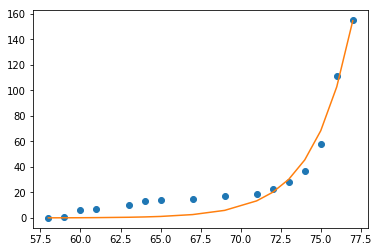

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')

In [17]:
results = {'infection_speed':a_, 'final_day': b_, 'total_infected':c_}

Número total de personas infectadas (en millones):

In [18]:
results['total_infected']/1e6

15.591512116535618

In [19]:
results['total_infected']-errors_dict['c_err']

-893504025549.1771

El pico de infección se obtiene para el día:

In [20]:
sol = int(fsolve(lambda x : logistic_model(x,*popt) - int(c_),b_))
sol

151

La fecha esperada para el pico de infección es:

In [21]:
specific_date = datetime(2020, 1, 1)
new_date = specific_date + timedelta(sol)
print('año:{} mes:{} día: {}'.format(new_date.year, new_date.month, new_date.day))

año:2020 mes:5 día: 31


Cuántos casos se espera para hoy?

In [22]:
dt = datetime.today()
target_date = datetime(dt.year, dt.month, dt.day)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('fecha objetivo {} corresponde al día {} con respecto al 01/01/20'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)
print('Predicción del número de infecciones: {}'.format(y_day))

fecha objetivo 2020-03-22 00:00:00 corresponde al día 81 con respecto al 01/01/20
Predicción del número de infecciones: 790.9822238290434


Para la fecha de máxima infecciones, cuántas infecciones?

In [23]:
target_date = datetime(2020, 5, 31)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('target date {} corresponds to day # {}'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)/1e6
print('Predicted number of infections: {}'.format(y_day))

target date 2020-05-31 00:00:00 corresponds to day # 151
Predicted number of infections: 15.591511995729325


## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

In [24]:
import matplotlib.dates as mdates
formatter = mdates.DateFormatter('%b %d')
target_date = datetime(2020, 4, 13)
initial_date = datetime(2020, 1, 1)
x_end = (target_date-initial_date).days
x_pronos = np.arange(start=x[0], stop=x_end, step=1)
y_pronos = logistic_model(x_pronos, *popt)/1e6

## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

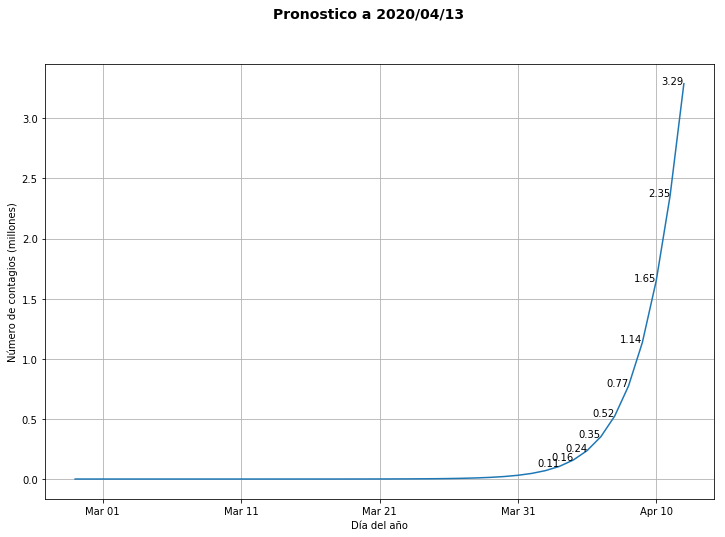

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.suptitle('Pronostico a 2020/04/13', fontsize=14, fontweight='bold')
ax.plot(x_pronos, y_pronos, '-')
for xi,yi in zip(x_pronos,y_pronos):
    if yi>0.1:
        ax.text(xi-0.8, yi, "%.2f" %yi, ha='center')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Día del año')
ax.set_ylabel('Número de contagios (millones)')
ax.grid(True)
fig.savefig('images/proyectionApril13.png')

<center>
<img src="images/proyectionApril13.png"/>
</center>

Por revisar:
* Usar red neuronal para mapear los datos. Generando un overfitting para generar un incremento artificial de datos, teniendo predicciones para intervalos intermedios de tiempo. Con esta data aumentada, realizar nuevamente el ajuste del modelo, ya que la interpretación de los parámetros de la ecuación permite interpretar información últil.

* Entrenar una red considerando datos más abundantes de otro país. No obstante esto genera el problema de que las condiciones de cada país son diferentes y por tanto la respuesta de cada país es diferente. Por tanto, se pensaría en un modelo global que sea la suma de todos. Luego se podría tratar de especializar las últimas capas del modelo en función de la data particular del país al estilo *transfer learning*.

## Conclusiones
* Quédate en la casa. Al momento los datos indicarían que estamos subiendo por la curva de infección en el primer estadio. 
* Es necesario relantizar dicha pendiente para no colapsar los sistemas médicos.
* Es necesario que las autoridades y otros sectores involucrados traten de proveerse de insumos médicos adicionales. A más de las máscaras, debería observarse la necesidad de respiradores artificiales.

## Conclusiones

* Si consideramos que la población del Ecuador es de 17 millones (https://countrymeters.info/es/Ecuador), 15 millones de contagiados, en la situación sin restricción de movilidad, implica un contagio del **89%**, estimando alcanzar el pico en 93 días más.

* Los cálculos aquí presentados son referenciales en función de la información disponible y de los modelos presentados. Dado que los factores de restricción de movilidad ya están en ejecución se esperaría que el número de infectados sea menor. Esta es una aproximación simplista del escenario. 


In [26]:
population = 17368483
rate = results['total_infected']/population*100.0
print(rate)
days_remaining = sol-df['Date'].iloc[0]
print(days_remaining)

89.76899201004267
93


### Artificial Neural Network

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using Theano backend.


In [28]:
def baseline_model():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(1e-4), metrics=['mae', 'mse'])
    return model

model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total para

In [29]:
x_stats = df["Date"].describe()
x_stats

count    16.000000
mean     67.750000
std       6.454972
min      58.000000
25%      62.500000
50%      68.000000
75%      73.250000
max      77.000000
Name: Date, dtype: float64

In [30]:
y_stats = df["Number_of_Cases"].describe()
y_stats

count     16.000000
mean      32.125000
std       42.665951
min        0.000000
25%        9.250000
50%       16.000000
75%       30.250000
max      155.000000
Name: Number_of_Cases, dtype: float64

In [31]:
x_norm = (np.array(x)-x_stats['mean'])/x_stats['std']
x_norm

array([-1.51046351, -1.35554417, -1.20062484, -1.0457055 , -0.73586684,
       -0.5809475 , -0.42602817, -0.1161895 ,  0.19364917,  0.50348784,
        0.65840717,  0.8133265 ,  0.96824584,  1.12316517,  1.2780845 ,
        1.43300384])

In [32]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)
kfold = KFold(n_splits=10)
y_ = np.array(y)
results = cross_val_score(estimator, x_norm, y_, cv=kfold)
print("baseline: {} mse {}".format(results.mean(), results.std()))

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Epoch 1/100
14/14 [==============================] - 0s 25ms/step - loss: 3124.4172 - mean_absolute_error: 36.5845 - mean_squared_error: 3124.4172
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 3115.5459 - mean_absolute_error: 36.4682 - mean_squared_error: 3115.5459
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 3104.3615 - mean_absolute_error: 36.3599 - mean_squared_error: 3104.3615
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 3092.7003 - mean_absolute_error: 36.1999 - mean_squared_error: 3092.7003
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 3071.7977 - mean_absolute_error: 35.9927 - mean_squared_error: 3071.7977
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 3050.1239 - mean_absolute_error: 35.7308 - mean_squared_error: 3050.1239
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 3017.4975 - mean_absolute_error: 35.4308 - mean_sq

14/14 [==============================] - 0s 5ms/step - loss: 533.1368 - mean_absolute_error: 17.5474 - mean_squared_error: 533.1368
Epoch 58/100
14/14 [==============================] - 0s 5ms/step - loss: 512.5692 - mean_absolute_error: 17.0207 - mean_squared_error: 512.5692
Epoch 59/100
14/14 [==============================] - 0s 4ms/step - loss: 557.8380 - mean_absolute_error: 18.2378 - mean_squared_error: 557.8380
Epoch 60/100
14/14 [==============================] - 0s 4ms/step - loss: 672.3019 - mean_absolute_error: 18.5310 - mean_squared_error: 672.3019
Epoch 61/100
14/14 [==============================] - 0s 4ms/step - loss: 540.9940 - mean_absolute_error: 17.6190 - mean_squared_error: 540.9940
Epoch 62/100
14/14 [==============================] - 0s 4ms/step - loss: 572.2147 - mean_absolute_error: 17.5135 - mean_squared_error: 572.2147
Epoch 63/100
14/14 [==============================] - 0s 4ms/step - loss: 569.9849 - mean_absolute_error: 17.1202 - mean_squared_error: 569.984

14/14 [==============================] - 0s 4ms/step - loss: 2733.0689 - mean_absolute_error: 32.8928 - mean_squared_error: 2733.0689
Epoch 14/100
14/14 [==============================] - 0s 4ms/step - loss: 2650.2519 - mean_absolute_error: 32.3828 - mean_squared_error: 2650.2519
Epoch 15/100
14/14 [==============================] - 0s 4ms/step - loss: 2551.4627 - mean_absolute_error: 31.6440 - mean_squared_error: 2551.4627
Epoch 16/100
14/14 [==============================] - 0s 4ms/step - loss: 2439.0920 - mean_absolute_error: 30.8872 - mean_squared_error: 2439.0920
Epoch 17/100
14/14 [==============================] - 0s 4ms/step - loss: 2297.7251 - mean_absolute_error: 29.6325 - mean_squared_error: 2297.7251
Epoch 18/100
14/14 [==============================] - 0s 4ms/step - loss: 2200.8102 - mean_absolute_error: 28.3459 - mean_squared_error: 2200.8102
Epoch 19/100
14/14 [==============================] - 0s 4ms/step - loss: 2007.3853 - mean_absolute_error: 26.8347 - mean_squared_e

14/14 [==============================] - 0s 4ms/step - loss: 560.5379 - mean_absolute_error: 17.6378 - mean_squared_error: 560.5379
Epoch 69/100
14/14 [==============================] - 0s 4ms/step - loss: 595.8760 - mean_absolute_error: 18.2031 - mean_squared_error: 595.8760
Epoch 70/100
14/14 [==============================] - 0s 4ms/step - loss: 532.3744 - mean_absolute_error: 17.4757 - mean_squared_error: 532.3744
Epoch 71/100
14/14 [==============================] - 0s 4ms/step - loss: 614.1780 - mean_absolute_error: 18.1741 - mean_squared_error: 614.1780
Epoch 72/100
14/14 [==============================] - 0s 4ms/step - loss: 600.8542 - mean_absolute_error: 18.1661 - mean_squared_error: 600.8542
Epoch 73/100
14/14 [==============================] - 0s 3ms/step - loss: 570.8627 - mean_absolute_error: 17.8704 - mean_squared_error: 570.8627
Epoch 74/100
14/14 [==============================] - 0s 4ms/step - loss: 569.7957 - mean_absolute_error: 17.7332 - mean_squared_error: 569.795

14/14 [==============================] - 0s 5ms/step - loss: 1219.8839 - mean_absolute_error: 17.8779 - mean_squared_error: 1219.8839
Epoch 24/100
14/14 [==============================] - 0s 4ms/step - loss: 1192.7060 - mean_absolute_error: 17.8064 - mean_squared_error: 1192.7060
Epoch 25/100
14/14 [==============================] - 0s 4ms/step - loss: 991.0431 - mean_absolute_error: 16.5862 - mean_squared_error: 991.0431
Epoch 26/100
14/14 [==============================] - 0s 4ms/step - loss: 934.8658 - mean_absolute_error: 16.9738 - mean_squared_error: 934.8658
Epoch 27/100
14/14 [==============================] - 0s 4ms/step - loss: 952.9459 - mean_absolute_error: 16.3301 - mean_squared_error: 952.9459
Epoch 28/100
14/14 [==============================] - 0s 4ms/step - loss: 804.5580 - mean_absolute_error: 15.9617 - mean_squared_error: 804.5580
Epoch 29/100
14/14 [==============================] - 0s 4ms/step - loss: 731.5819 - mean_absolute_error: 16.6910 - mean_squared_error: 731

14/14 [==============================] - 0s 4ms/step - loss: 540.7721 - mean_absolute_error: 16.5106 - mean_squared_error: 540.7721
Epoch 80/100
14/14 [==============================] - 0s 4ms/step - loss: 591.1546 - mean_absolute_error: 17.9320 - mean_squared_error: 591.1546
Epoch 81/100
14/14 [==============================] - 0s 4ms/step - loss: 537.0617 - mean_absolute_error: 16.3856 - mean_squared_error: 537.0617
Epoch 82/100
14/14 [==============================] - 0s 4ms/step - loss: 515.7722 - mean_absolute_error: 16.5419 - mean_squared_error: 515.7722
Epoch 83/100
14/14 [==============================] - 0s 4ms/step - loss: 623.3170 - mean_absolute_error: 17.2906 - mean_squared_error: 623.3170
Epoch 84/100
14/14 [==============================] - 0s 4ms/step - loss: 504.5201 - mean_absolute_error: 16.4748 - mean_squared_error: 504.5201
Epoch 85/100
14/14 [==============================] - 0s 4ms/step - loss: 462.4761 - mean_absolute_error: 16.1368 - mean_squared_error: 462.476

14/14 [==============================] - 0s 4ms/step - loss: 617.8005 - mean_absolute_error: 16.7974 - mean_squared_error: 617.8005
Epoch 35/100
14/14 [==============================] - 0s 4ms/step - loss: 707.6448 - mean_absolute_error: 18.3615 - mean_squared_error: 707.6448
Epoch 36/100
14/14 [==============================] - 0s 4ms/step - loss: 694.1525 - mean_absolute_error: 18.2972 - mean_squared_error: 694.1525
Epoch 37/100
14/14 [==============================] - 0s 5ms/step - loss: 476.9913 - mean_absolute_error: 16.0119 - mean_squared_error: 476.9913
Epoch 38/100
14/14 [==============================] - 0s 4ms/step - loss: 659.1312 - mean_absolute_error: 17.6325 - mean_squared_error: 659.1312
Epoch 39/100
14/14 [==============================] - 0s 4ms/step - loss: 572.3646 - mean_absolute_error: 17.1709 - mean_squared_error: 572.3646
Epoch 40/100
14/14 [==============================] - 0s 4ms/step - loss: 619.7608 - mean_absolute_error: 18.0812 - mean_squared_error: 619.760

14/14 [==============================] - 0s 5ms/step - loss: 481.5549 - mean_absolute_error: 16.1839 - mean_squared_error: 481.5549
Epoch 91/100
14/14 [==============================] - 0s 5ms/step - loss: 549.5162 - mean_absolute_error: 17.0726 - mean_squared_error: 549.5162
Epoch 92/100
14/14 [==============================] - 0s 5ms/step - loss: 568.2361 - mean_absolute_error: 16.3421 - mean_squared_error: 568.2361
Epoch 93/100
14/14 [==============================] - 0s 5ms/step - loss: 575.6657 - mean_absolute_error: 17.1425 - mean_squared_error: 575.6657
Epoch 94/100
14/14 [==============================] - 0s 3ms/step - loss: 558.1143 - mean_absolute_error: 17.0239 - mean_squared_error: 558.1143
Epoch 95/100
14/14 [==============================] - 0s 4ms/step - loss: 642.8027 - mean_absolute_error: 17.9952 - mean_squared_error: 642.8027
Epoch 96/100
14/14 [==============================] - 0s 5ms/step - loss: 624.1623 - mean_absolute_error: 18.2623 - mean_squared_error: 624.162

14/14 [==============================] - 0s 4ms/step - loss: 637.9096 - mean_absolute_error: 18.2462 - mean_squared_error: 637.9096
Epoch 46/100
14/14 [==============================] - 0s 4ms/step - loss: 606.2415 - mean_absolute_error: 17.6712 - mean_squared_error: 606.2415
Epoch 47/100
14/14 [==============================] - 0s 4ms/step - loss: 554.8989 - mean_absolute_error: 16.6644 - mean_squared_error: 554.8989
Epoch 48/100
14/14 [==============================] - 0s 5ms/step - loss: 584.0910 - mean_absolute_error: 17.0986 - mean_squared_error: 584.0910
Epoch 49/100
14/14 [==============================] - 0s 4ms/step - loss: 579.0302 - mean_absolute_error: 17.3529 - mean_squared_error: 579.0302
Epoch 50/100
14/14 [==============================] - 0s 3ms/step - loss: 586.2955 - mean_absolute_error: 17.2254 - mean_squared_error: 586.2955
Epoch 51/100
14/14 [==============================] - 0s 3ms/step - loss: 611.0926 - mean_absolute_error: 17.4764 - mean_squared_error: 611.092

14/14 [==============================] - 0s 3ms/step - loss: 3031.6663 - mean_absolute_error: 33.0346 - mean_squared_error: 3031.6663
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 3023.1662 - mean_absolute_error: 32.9298 - mean_squared_error: 3023.1662
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 3014.0191 - mean_absolute_error: 32.8481 - mean_squared_error: 3014.0191
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 2999.3997 - mean_absolute_error: 32.7075 - mean_squared_error: 2999.3997
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 2988.1175 - mean_absolute_error: 32.5945 - mean_squared_error: 2988.1175
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 2966.2555 - mean_absolute_error: 32.4339 - mean_squared_error: 2966.2555
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 2944.4091 - mean_absolute_error: 32.2529 - mean_squared_error: 

14/14 [==============================] - 0s 5ms/step - loss: 382.1510 - mean_absolute_error: 13.8413 - mean_squared_error: 382.1510
Epoch 58/100
14/14 [==============================] - 0s 4ms/step - loss: 503.9524 - mean_absolute_error: 15.6375 - mean_squared_error: 503.9524
Epoch 59/100
14/14 [==============================] - 0s 3ms/step - loss: 433.0516 - mean_absolute_error: 14.6486 - mean_squared_error: 433.0516
Epoch 60/100
14/14 [==============================] - 0s 4ms/step - loss: 446.5657 - mean_absolute_error: 14.7694 - mean_squared_error: 446.5657
Epoch 61/100
14/14 [==============================] - 0s 5ms/step - loss: 449.0728 - mean_absolute_error: 14.8300 - mean_squared_error: 449.0728
Epoch 62/100
14/14 [==============================] - 0s 3ms/step - loss: 550.3728 - mean_absolute_error: 15.6794 - mean_squared_error: 550.3728
Epoch 63/100
14/14 [==============================] - 0s 3ms/step - loss: 434.3692 - mean_absolute_error: 14.2901 - mean_squared_error: 434.369

15/15 [==============================] - 0s 4ms/step - loss: 2383.2733 - mean_absolute_error: 28.1408 - mean_squared_error: 2383.2733
Epoch 14/100
15/15 [==============================] - 0s 4ms/step - loss: 2293.1981 - mean_absolute_error: 27.6562 - mean_squared_error: 2293.1981
Epoch 15/100
15/15 [==============================] - 0s 4ms/step - loss: 2210.8973 - mean_absolute_error: 26.9105 - mean_squared_error: 2210.8973
Epoch 16/100
15/15 [==============================] - 0s 4ms/step - loss: 2082.0725 - mean_absolute_error: 26.1180 - mean_squared_error: 2082.0725
Epoch 17/100
15/15 [==============================] - 0s 4ms/step - loss: 1977.4324 - mean_absolute_error: 25.3798 - mean_squared_error: 1977.4324
Epoch 18/100
15/15 [==============================] - 0s 4ms/step - loss: 1871.8337 - mean_absolute_error: 24.2589 - mean_squared_error: 1871.8337
Epoch 19/100
15/15 [==============================] - 0s 4ms/step - loss: 1730.8369 - mean_absolute_error: 22.7810 - mean_squared_e

15/15 [==============================] - 0s 4ms/step - loss: 423.4712 - mean_absolute_error: 15.2674 - mean_squared_error: 423.4712
Epoch 70/100
15/15 [==============================] - 0s 5ms/step - loss: 491.6686 - mean_absolute_error: 15.0510 - mean_squared_error: 491.6686
Epoch 71/100
15/15 [==============================] - 0s 4ms/step - loss: 480.2571 - mean_absolute_error: 15.7899 - mean_squared_error: 480.2571
Epoch 72/100
15/15 [==============================] - 0s 4ms/step - loss: 417.8559 - mean_absolute_error: 14.9618 - mean_squared_error: 417.8559
Epoch 73/100
15/15 [==============================] - 0s 4ms/step - loss: 406.4924 - mean_absolute_error: 14.2953 - mean_squared_error: 406.4924
Epoch 74/100
15/15 [==============================] - 0s 4ms/step - loss: 437.1264 - mean_absolute_error: 15.3158 - mean_squared_error: 437.1264
Epoch 75/100
15/15 [==============================] - 0s 4ms/step - loss: 446.3504 - mean_absolute_error: 15.0749 - mean_squared_error: 446.350

15/15 [==============================] - 0s 6ms/step - loss: 1314.3119 - mean_absolute_error: 17.8607 - mean_squared_error: 1314.3119
Epoch 25/100
15/15 [==============================] - 0s 5ms/step - loss: 1208.7198 - mean_absolute_error: 17.0222 - mean_squared_error: 1208.7198
Epoch 26/100
15/15 [==============================] - 0s 3ms/step - loss: 1074.0519 - mean_absolute_error: 16.3404 - mean_squared_error: 1074.0519
Epoch 27/100
15/15 [==============================] - 0s 8ms/step - loss: 978.9261 - mean_absolute_error: 16.1097 - mean_squared_error: 978.9261
Epoch 28/100
15/15 [==============================] - 0s 4ms/step - loss: 926.5445 - mean_absolute_error: 16.6030 - mean_squared_error: 926.5445
Epoch 29/100
15/15 [==============================] - 0s 4ms/step - loss: 827.6640 - mean_absolute_error: 16.2550 - mean_squared_error: 827.6640
Epoch 30/100
15/15 [==============================] - 0s 4ms/step - loss: 698.3053 - mean_absolute_error: 15.6932 - mean_squared_error: 6

15/15 [==============================] - 0s 4ms/step - loss: 494.7708 - mean_absolute_error: 15.3194 - mean_squared_error: 494.7708
Epoch 81/100
15/15 [==============================] - 0s 4ms/step - loss: 460.6856 - mean_absolute_error: 15.1854 - mean_squared_error: 460.6856
Epoch 82/100
15/15 [==============================] - 0s 4ms/step - loss: 461.1488 - mean_absolute_error: 14.8331 - mean_squared_error: 461.1488
Epoch 83/100
15/15 [==============================] - 0s 4ms/step - loss: 540.2999 - mean_absolute_error: 16.0433 - mean_squared_error: 540.2999
Epoch 84/100
15/15 [==============================] - 0s 4ms/step - loss: 478.0235 - mean_absolute_error: 15.2316 - mean_squared_error: 478.0235
Epoch 85/100
15/15 [==============================] - 0s 4ms/step - loss: 534.1114 - mean_absolute_error: 16.0004 - mean_squared_error: 534.1114
Epoch 86/100
15/15 [==============================] - 0s 4ms/step - loss: 548.0452 - mean_absolute_error: 15.7054 - mean_squared_error: 548.045

15/15 [==============================] - 0s 4ms/step - loss: 518.6254 - mean_absolute_error: 13.0468 - mean_squared_error: 518.6254
Epoch 36/100
15/15 [==============================] - 0s 8ms/step - loss: 564.9030 - mean_absolute_error: 14.2214 - mean_squared_error: 564.9030
Epoch 37/100
15/15 [==============================] - 0s 4ms/step - loss: 545.8251 - mean_absolute_error: 14.0590 - mean_squared_error: 545.8251
Epoch 38/100
15/15 [==============================] - 0s 7ms/step - loss: 550.0645 - mean_absolute_error: 13.8638 - mean_squared_error: 550.0645
Epoch 39/100
15/15 [==============================] - 0s 3ms/step - loss: 469.5217 - mean_absolute_error: 14.0198 - mean_squared_error: 469.5217
Epoch 40/100
15/15 [==============================] - 0s 4ms/step - loss: 539.7789 - mean_absolute_error: 14.7745 - mean_squared_error: 539.7789
Epoch 41/100
15/15 [==============================] - 0s 4ms/step - loss: 526.6848 - mean_absolute_error: 14.1139 - mean_squared_error: 526.684

15/15 [==============================] - 0s 4ms/step - loss: 536.0877 - mean_absolute_error: 14.8617 - mean_squared_error: 536.0877
Epoch 92/100
15/15 [==============================] - 0s 4ms/step - loss: 488.1290 - mean_absolute_error: 13.2466 - mean_squared_error: 488.1290
Epoch 93/100
15/15 [==============================] - 0s 4ms/step - loss: 519.5200 - mean_absolute_error: 14.1481 - mean_squared_error: 519.5200
Epoch 94/100
15/15 [==============================] - 0s 4ms/step - loss: 490.1843 - mean_absolute_error: 13.6668 - mean_squared_error: 490.1843
Epoch 95/100
15/15 [==============================] - 0s 4ms/step - loss: 507.3121 - mean_absolute_error: 14.4099 - mean_squared_error: 507.3121
Epoch 96/100
15/15 [==============================] - 0s 4ms/step - loss: 474.4413 - mean_absolute_error: 13.9262 - mean_squared_error: 474.4413
Epoch 97/100
15/15 [==============================] - 0s 4ms/step - loss: 477.8402 - mean_absolute_error: 13.3144 - mean_squared_error: 477.840

15/15 [==============================] - 0s 4ms/step - loss: 267.5247 - mean_absolute_error: 11.3965 - mean_squared_error: 267.5247
Epoch 48/100
15/15 [==============================] - 0s 4ms/step - loss: 203.5603 - mean_absolute_error: 10.1213 - mean_squared_error: 203.5603
Epoch 49/100
15/15 [==============================] - 0s 5ms/step - loss: 230.7683 - mean_absolute_error: 10.0693 - mean_squared_error: 230.7683
Epoch 50/100
15/15 [==============================] - 0s 4ms/step - loss: 228.1962 - mean_absolute_error: 10.2527 - mean_squared_error: 228.1962
Epoch 51/100
15/15 [==============================] - 0s 4ms/step - loss: 229.5637 - mean_absolute_error: 10.5595 - mean_squared_error: 229.5637
Epoch 52/100
15/15 [==============================] - 0s 5ms/step - loss: 212.8660 - mean_absolute_error: 10.5100 - mean_squared_error: 212.8660
Epoch 53/100
15/15 [==============================] - 0s 3ms/step - loss: 277.9589 - mean_absolute_error: 11.4523 - mean_squared_error: 277.958

In [33]:
y_reg = model.predict(x_norm.reshape(-1,1))
y_reg

array([[0.04176669],
       [0.03748291],
       [0.03319915],
       [0.02891537],
       [0.02034787],
       [0.0160641 ],
       [0.01178035],
       [0.00321282],
       [0.00270953],
       [0.00704479],
       [0.00921242],
       [0.01138004],
       [0.01354767],
       [0.0157153 ],
       [0.01788294],
       [0.02005056]], dtype=float32)

In [34]:
# from sklearn.model_selection import train_test_split
# x_ = np.array(x)
# y_ = np.array(y)
# x_train, x_test, y_train, y_test = train_test_split(x_,y_, test_size=0.2, random_state=42, shuffle=True)
# print('Numero de casos de entrenamiento: {}'.format(len(x_train)))
# print('Numero de casos de testeo: {}'.format(len(x_test)))
# print("x: {}".format(x_))
# print("y: {}".format(y_))
# print("x_train: {}".format(x_train))
# print("y_train: {}".format(y_train))
# print("x_test: {}".format(x_test))
# print("y_test: {}".format(y_test))
      

In [35]:
history = model.fit(x_norm, y, verbose=1, epochs=1500)

Epoch 1/1500
16/16 [==============================] - 0s 837us/step - loss: 2737.5303 - mean_absolute_error: 32.1117 - mean_squared_error: 2737.5303
Epoch 2/1500
16/16 [==============================] - 0s 985us/step - loss: 2732.5771 - mean_absolute_error: 32.0625 - mean_squared_error: 2732.5771
Epoch 3/1500
16/16 [==============================] - 0s 1ms/step - loss: 2728.7495 - mean_absolute_error: 32.0219 - mean_squared_error: 2728.7495
Epoch 4/1500
16/16 [==============================] - 0s 1ms/step - loss: 2725.9265 - mean_absolute_error: 31.9852 - mean_squared_error: 2725.9265
Epoch 5/1500
16/16 [==============================] - 0s 2ms/step - loss: 2720.5342 - mean_absolute_error: 31.9342 - mean_squared_error: 2720.5342
Epoch 6/1500
16/16 [==============================] - 0s 1ms/step - loss: 2716.6455 - mean_absolute_error: 31.8929 - mean_squared_error: 2716.6455
Epoch 7/1500
16/16 [==============================] - 0s 2ms/step - loss: 2711.7976 - mean_absolute_error: 31.8415

Epoch 57/1500
16/16 [==============================] - 0s 2ms/step - loss: 817.4442 - mean_absolute_error: 15.1298 - mean_squared_error: 817.4442
Epoch 58/1500
16/16 [==============================] - 0s 1ms/step - loss: 701.3740 - mean_absolute_error: 14.6947 - mean_squared_error: 701.3740
Epoch 59/1500
16/16 [==============================] - 0s 1ms/step - loss: 741.2332 - mean_absolute_error: 15.1374 - mean_squared_error: 741.2332
Epoch 60/1500
16/16 [==============================] - 0s 1ms/step - loss: 672.2283 - mean_absolute_error: 15.0054 - mean_squared_error: 672.2283
Epoch 61/1500
16/16 [==============================] - 0s 1ms/step - loss: 641.4449 - mean_absolute_error: 14.2735 - mean_squared_error: 641.4449
Epoch 62/1500
16/16 [==============================] - 0s 1ms/step - loss: 605.5930 - mean_absolute_error: 14.2889 - mean_squared_error: 605.5930
Epoch 63/1500
16/16 [==============================] - 0s 1ms/step - loss: 542.6638 - mean_absolute_error: 14.8217 - mean_sq

Epoch 114/1500
16/16 [==============================] - 0s 1ms/step - loss: 470.4698 - mean_absolute_error: 14.9901 - mean_squared_error: 470.4698
Epoch 115/1500
16/16 [==============================] - 0s 1ms/step - loss: 449.3101 - mean_absolute_error: 15.1020 - mean_squared_error: 449.3101
Epoch 116/1500
16/16 [==============================] - 0s 4ms/step - loss: 432.6285 - mean_absolute_error: 14.7991 - mean_squared_error: 432.6285
Epoch 117/1500
16/16 [==============================] - 0s 2ms/step - loss: 433.5532 - mean_absolute_error: 14.6623 - mean_squared_error: 433.5532
Epoch 118/1500
16/16 [==============================] - 0s 1ms/step - loss: 416.8549 - mean_absolute_error: 14.9916 - mean_squared_error: 416.8549
Epoch 119/1500
16/16 [==============================] - 0s 1ms/step - loss: 476.5085 - mean_absolute_error: 15.0583 - mean_squared_error: 476.5085
Epoch 120/1500
16/16 [==============================] - 0s 1ms/step - loss: 492.7163 - mean_absolute_error: 15.6694 - 

Epoch 170/1500
16/16 [==============================] - 0s 2ms/step - loss: 422.5265 - mean_absolute_error: 13.5130 - mean_squared_error: 422.5265
Epoch 171/1500
16/16 [==============================] - 0s 3ms/step - loss: 476.0068 - mean_absolute_error: 14.1649 - mean_squared_error: 476.0068
Epoch 172/1500
16/16 [==============================] - 0s 2ms/step - loss: 344.5769 - mean_absolute_error: 12.4082 - mean_squared_error: 344.5769
Epoch 173/1500
16/16 [==============================] - 0s 2ms/step - loss: 374.2711 - mean_absolute_error: 12.5752 - mean_squared_error: 374.2711
Epoch 174/1500
16/16 [==============================] - 0s 1ms/step - loss: 369.3726 - mean_absolute_error: 13.0592 - mean_squared_error: 369.3726
Epoch 175/1500
16/16 [==============================] - 0s 1ms/step - loss: 447.9694 - mean_absolute_error: 13.6790 - mean_squared_error: 447.9694
Epoch 176/1500
16/16 [==============================] - 0s 1ms/step - loss: 377.8253 - mean_absolute_error: 12.8954 - 

Epoch 226/1500
16/16 [==============================] - 0s 2ms/step - loss: 296.4444 - mean_absolute_error: 11.1957 - mean_squared_error: 296.4444
Epoch 227/1500
16/16 [==============================] - 0s 2ms/step - loss: 347.7929 - mean_absolute_error: 11.9995 - mean_squared_error: 347.7929
Epoch 228/1500
16/16 [==============================] - 0s 2ms/step - loss: 357.1277 - mean_absolute_error: 11.8931 - mean_squared_error: 357.1277
Epoch 229/1500
16/16 [==============================] - 0s 1ms/step - loss: 319.6925 - mean_absolute_error: 11.7066 - mean_squared_error: 319.6925
Epoch 230/1500
16/16 [==============================] - 0s 1ms/step - loss: 335.8614 - mean_absolute_error: 11.8084 - mean_squared_error: 335.8614
Epoch 231/1500
16/16 [==============================] - 0s 1ms/step - loss: 284.0069 - mean_absolute_error: 10.7209 - mean_squared_error: 284.0069
Epoch 232/1500
16/16 [==============================] - 0s 1ms/step - loss: 323.2852 - mean_absolute_error: 11.1940 - 

Epoch 282/1500
16/16 [==============================] - 0s 1ms/step - loss: 220.1523 - mean_absolute_error: 9.4686 - mean_squared_error: 220.1523
Epoch 283/1500
16/16 [==============================] - 0s 1ms/step - loss: 243.5327 - mean_absolute_error: 9.6559 - mean_squared_error: 243.5327
Epoch 284/1500
16/16 [==============================] - 0s 1ms/step - loss: 203.6198 - mean_absolute_error: 8.6736 - mean_squared_error: 203.6198
Epoch 285/1500
16/16 [==============================] - 0s 6ms/step - loss: 289.9977 - mean_absolute_error: 11.0763 - mean_squared_error: 289.9977
Epoch 286/1500
16/16 [==============================] - 0s 2ms/step - loss: 213.2855 - mean_absolute_error: 9.4587 - mean_squared_error: 213.2855
Epoch 287/1500
16/16 [==============================] - 0s 1ms/step - loss: 170.6740 - mean_absolute_error: 8.3983 - mean_squared_error: 170.6740
Epoch 288/1500
16/16 [==============================] - 0s 1ms/step - loss: 174.1536 - mean_absolute_error: 8.7516 - mean_s

16/16 [==============================] - 0s 1ms/step - loss: 138.0916 - mean_absolute_error: 7.5870 - mean_squared_error: 138.0916
Epoch 339/1500
16/16 [==============================] - 0s 1ms/step - loss: 147.6373 - mean_absolute_error: 7.7217 - mean_squared_error: 147.6373
Epoch 340/1500
16/16 [==============================] - 0s 1ms/step - loss: 133.5824 - mean_absolute_error: 6.9178 - mean_squared_error: 133.5824
Epoch 341/1500
16/16 [==============================] - 0s 1ms/step - loss: 141.0045 - mean_absolute_error: 7.0458 - mean_squared_error: 141.0045
Epoch 342/1500
16/16 [==============================] - 0s 2ms/step - loss: 161.5268 - mean_absolute_error: 7.7857 - mean_squared_error: 161.5268
Epoch 343/1500
16/16 [==============================] - 0s 2ms/step - loss: 123.0845 - mean_absolute_error: 7.0460 - mean_squared_error: 123.0845
Epoch 344/1500
16/16 [==============================] - 0s 2ms/step - loss: 153.8541 - mean_absolute_error: 7.5820 - mean_squared_error: 15

Epoch 395/1500
16/16 [==============================] - 0s 2ms/step - loss: 60.6708 - mean_absolute_error: 4.9805 - mean_squared_error: 60.6708
Epoch 396/1500
16/16 [==============================] - 0s 2ms/step - loss: 39.8082 - mean_absolute_error: 4.4076 - mean_squared_error: 39.8082
Epoch 397/1500
16/16 [==============================] - 0s 2ms/step - loss: 67.1131 - mean_absolute_error: 4.8575 - mean_squared_error: 67.1131
Epoch 398/1500
16/16 [==============================] - 0s 2ms/step - loss: 39.9056 - mean_absolute_error: 3.8205 - mean_squared_error: 39.9056
Epoch 399/1500
16/16 [==============================] - 0s 3ms/step - loss: 56.2092 - mean_absolute_error: 4.5174 - mean_squared_error: 56.2092
Epoch 400/1500
16/16 [==============================] - 0s 2ms/step - loss: 51.7080 - mean_absolute_error: 4.1423 - mean_squared_error: 51.7080
Epoch 401/1500
16/16 [==============================] - 0s 2ms/step - loss: 38.9648 - mean_absolute_error: 3.9383 - mean_squared_error: 

Epoch 452/1500
16/16 [==============================] - 0s 2ms/step - loss: 19.9675 - mean_absolute_error: 2.6913 - mean_squared_error: 19.9675
Epoch 453/1500
16/16 [==============================] - 0s 1ms/step - loss: 17.3242 - mean_absolute_error: 2.4978 - mean_squared_error: 17.3242
Epoch 454/1500
16/16 [==============================] - 0s 1ms/step - loss: 13.3234 - mean_absolute_error: 1.8974 - mean_squared_error: 13.3234
Epoch 455/1500
16/16 [==============================] - 0s 1ms/step - loss: 12.4405 - mean_absolute_error: 2.2726 - mean_squared_error: 12.4405
Epoch 456/1500
16/16 [==============================] - 0s 2ms/step - loss: 19.0600 - mean_absolute_error: 2.5544 - mean_squared_error: 19.0600
Epoch 457/1500
16/16 [==============================] - 0s 1ms/step - loss: 15.1003 - mean_absolute_error: 2.6751 - mean_squared_error: 15.1003
Epoch 458/1500
16/16 [==============================] - 0s 1ms/step - loss: 13.6442 - mean_absolute_error: 2.6130 - mean_squared_error: 

16/16 [==============================] - 0s 1ms/step - loss: 20.4060 - mean_absolute_error: 3.0276 - mean_squared_error: 20.4060
Epoch 510/1500
16/16 [==============================] - 0s 2ms/step - loss: 14.5436 - mean_absolute_error: 2.7900 - mean_squared_error: 14.5436
Epoch 511/1500
16/16 [==============================] - 0s 2ms/step - loss: 19.4012 - mean_absolute_error: 3.1453 - mean_squared_error: 19.4012
Epoch 512/1500
16/16 [==============================] - 0s 2ms/step - loss: 10.8388 - mean_absolute_error: 1.8473 - mean_squared_error: 10.8388
Epoch 513/1500
16/16 [==============================] - 0s 1ms/step - loss: 17.9257 - mean_absolute_error: 2.4463 - mean_squared_error: 17.9257
Epoch 514/1500
16/16 [==============================] - 0s 1ms/step - loss: 15.5395 - mean_absolute_error: 1.9333 - mean_squared_error: 15.5395
Epoch 515/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.1128 - mean_absolute_error: 1.3528 - mean_squared_error: 3.1128
Epoch 516

Epoch 567/1500
16/16 [==============================] - 0s 1ms/step - loss: 8.2808 - mean_absolute_error: 1.8373 - mean_squared_error: 8.2808
Epoch 568/1500
16/16 [==============================] - 0s 1ms/step - loss: 9.5652 - mean_absolute_error: 2.2644 - mean_squared_error: 9.5652
Epoch 569/1500
16/16 [==============================] - 0s 1ms/step - loss: 15.7145 - mean_absolute_error: 2.8591 - mean_squared_error: 15.7145
Epoch 570/1500
16/16 [==============================] - 0s 1ms/step - loss: 4.0871 - mean_absolute_error: 1.5478 - mean_squared_error: 4.0871
Epoch 571/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.8527 - mean_absolute_error: 1.7804 - mean_squared_error: 6.8527
Epoch 572/1500
16/16 [==============================] - 0s 1ms/step - loss: 2.8775 - mean_absolute_error: 1.4286 - mean_squared_error: 2.8775
Epoch 573/1500
16/16 [==============================] - 0s 1ms/step - loss: 5.9403 - mean_absolute_error: 1.5849 - mean_squared_error: 5.9403
Epoc

Epoch 625/1500
16/16 [==============================] - 0s 1ms/step - loss: 3.9831 - mean_absolute_error: 1.3573 - mean_squared_error: 3.9831
Epoch 626/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.3707 - mean_absolute_error: 1.4923 - mean_squared_error: 6.3707
Epoch 627/1500
16/16 [==============================] - 0s 1ms/step - loss: 9.9155 - mean_absolute_error: 2.0667 - mean_squared_error: 9.9155
Epoch 628/1500
16/16 [==============================] - 0s 1ms/step - loss: 17.1010 - mean_absolute_error: 2.9397 - mean_squared_error: 17.1010
Epoch 629/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.5092 - mean_absolute_error: 1.9285 - mean_squared_error: 6.5092
Epoch 630/1500
16/16 [==============================] - 0s 1ms/step - loss: 6.3726 - mean_absolute_error: 1.7323 - mean_squared_error: 6.3726
Epoch 631/1500
16/16 [==============================] - 0s 2ms/step - loss: 3.1252 - mean_absolute_error: 1.2825 - mean_squared_error: 3.1252
Epoc

Epoch 683/1500
16/16 [==============================] - 0s 2ms/step - loss: 24.9501 - mean_absolute_error: 3.6916 - mean_squared_error: 24.9501
Epoch 684/1500
16/16 [==============================] - 0s 2ms/step - loss: 9.1943 - mean_absolute_error: 2.6756 - mean_squared_error: 9.1943
Epoch 685/1500
16/16 [==============================] - 0s 2ms/step - loss: 8.3532 - mean_absolute_error: 1.5470 - mean_squared_error: 8.3532
Epoch 686/1500
16/16 [==============================] - 0s 2ms/step - loss: 16.2415 - mean_absolute_error: 2.0477 - mean_squared_error: 16.2415
Epoch 687/1500
16/16 [==============================] - 0s 2ms/step - loss: 11.7134 - mean_absolute_error: 1.9892 - mean_squared_error: 11.7134
Epoch 688/1500
16/16 [==============================] - 0s 2ms/step - loss: 2.3463 - mean_absolute_error: 1.2308 - mean_squared_error: 2.3463
Epoch 689/1500
16/16 [==============================] - 0s 1ms/step - loss: 2.0773 - mean_absolute_error: 0.9886 - mean_squared_error: 2.0773


Epoch 741/1500
16/16 [==============================] - 0s 2ms/step - loss: 22.6299 - mean_absolute_error: 3.3141 - mean_squared_error: 22.6299
Epoch 742/1500
16/16 [==============================] - 0s 2ms/step - loss: 32.9214 - mean_absolute_error: 3.8315 - mean_squared_error: 32.9214
Epoch 743/1500
16/16 [==============================] - 0s 2ms/step - loss: 9.5520 - mean_absolute_error: 1.9807 - mean_squared_error: 9.5520
Epoch 744/1500
16/16 [==============================] - 0s 2ms/step - loss: 24.0481 - mean_absolute_error: 2.6681 - mean_squared_error: 24.0481
Epoch 745/1500
16/16 [==============================] - 0s 2ms/step - loss: 12.6560 - mean_absolute_error: 2.0304 - mean_squared_error: 12.6560
Epoch 746/1500
16/16 [==============================] - 0s 2ms/step - loss: 1.9659 - mean_absolute_error: 1.2259 - mean_squared_error: 1.9659
Epoch 747/1500
16/16 [==============================] - 0s 2ms/step - loss: 1.0369 - mean_absolute_error: 0.7457 - mean_squared_error: 1.036

Epoch 799/1500
16/16 [==============================] - 0s 2ms/step - loss: 6.2002 - mean_absolute_error: 1.6515 - mean_squared_error: 6.2002
Epoch 800/1500
16/16 [==============================] - 0s 2ms/step - loss: 1.9066 - mean_absolute_error: 1.1585 - mean_squared_error: 1.9066
Epoch 801/1500
16/16 [==============================] - 0s 2ms/step - loss: 11.9411 - mean_absolute_error: 1.8206 - mean_squared_error: 11.9411
Epoch 802/1500
16/16 [==============================] - 0s 3ms/step - loss: 23.2960 - mean_absolute_error: 2.7226 - mean_squared_error: 23.2960
Epoch 803/1500
16/16 [==============================] - 0s 3ms/step - loss: 4.8316 - mean_absolute_error: 1.6030 - mean_squared_error: 4.8316
Epoch 804/1500
16/16 [==============================] - 0s 3ms/step - loss: 1.0045 - mean_absolute_error: 0.8446 - mean_squared_error: 1.0045
Epoch 805/1500
16/16 [==============================] - 0s 2ms/step - loss: 6.8162 - mean_absolute_error: 1.3951 - mean_squared_error: 6.8162
Ep

Epoch 857/1500
16/16 [==============================] - 0s 2ms/step - loss: 13.5906 - mean_absolute_error: 2.4227 - mean_squared_error: 13.5906
Epoch 858/1500
16/16 [==============================] - 0s 3ms/step - loss: 13.5366 - mean_absolute_error: 2.0000 - mean_squared_error: 13.5366
Epoch 859/1500
16/16 [==============================] - 0s 3ms/step - loss: 8.4646 - mean_absolute_error: 1.8802 - mean_squared_error: 8.4646
Epoch 860/1500
16/16 [==============================] - 0s 3ms/step - loss: 7.5962 - mean_absolute_error: 1.6341 - mean_squared_error: 7.5962
Epoch 861/1500
16/16 [==============================] - 0s 2ms/step - loss: 12.9856 - mean_absolute_error: 2.2827 - mean_squared_error: 12.9856
Epoch 862/1500
16/16 [==============================] - 0s 2ms/step - loss: 19.7203 - mean_absolute_error: 2.5878 - mean_squared_error: 19.7203
Epoch 863/1500
16/16 [==============================] - 0s 3ms/step - loss: 18.8263 - mean_absolute_error: 2.5777 - mean_squared_error: 18.8

Epoch 915/1500
16/16 [==============================] - 0s 3ms/step - loss: 16.1668 - mean_absolute_error: 2.3561 - mean_squared_error: 16.1668
Epoch 916/1500
16/16 [==============================] - 0s 3ms/step - loss: 24.5503 - mean_absolute_error: 3.3755 - mean_squared_error: 24.5503
Epoch 917/1500
16/16 [==============================] - 0s 2ms/step - loss: 15.8584 - mean_absolute_error: 2.8034 - mean_squared_error: 15.8584
Epoch 918/1500
16/16 [==============================] - 0s 3ms/step - loss: 13.2204 - mean_absolute_error: 2.4445 - mean_squared_error: 13.2204
Epoch 919/1500
16/16 [==============================] - 0s 3ms/step - loss: 2.2080 - mean_absolute_error: 1.3399 - mean_squared_error: 2.2080
Epoch 920/1500
16/16 [==============================] - 0s 2ms/step - loss: 11.5769 - mean_absolute_error: 2.1916 - mean_squared_error: 11.5769
Epoch 921/1500
16/16 [==============================] - 0s 2ms/step - loss: 12.0149 - mean_absolute_error: 1.7694 - mean_squared_error: 12

Epoch 973/1500
16/16 [==============================] - 0s 2ms/step - loss: 2.9987 - mean_absolute_error: 1.4524 - mean_squared_error: 2.9987
Epoch 974/1500
16/16 [==============================] - 0s 2ms/step - loss: 13.5750 - mean_absolute_error: 2.1648 - mean_squared_error: 13.5750
Epoch 975/1500
16/16 [==============================] - 0s 3ms/step - loss: 24.2576 - mean_absolute_error: 2.5698 - mean_squared_error: 24.2576
Epoch 976/1500
16/16 [==============================] - 0s 3ms/step - loss: 11.0727 - mean_absolute_error: 2.2020 - mean_squared_error: 11.0727
Epoch 977/1500
16/16 [==============================] - 0s 3ms/step - loss: 1.6207 - mean_absolute_error: 1.0016 - mean_squared_error: 1.6207
Epoch 978/1500
16/16 [==============================] - 0s 2ms/step - loss: 3.5393 - mean_absolute_error: 1.3552 - mean_squared_error: 3.5393
Epoch 979/1500
16/16 [==============================] - 0s 3ms/step - loss: 2.7129 - mean_absolute_error: 1.0051 - mean_squared_error: 2.7129


Epoch 1031/1500
16/16 [==============================] - 0s 2ms/step - loss: 5.5873 - mean_absolute_error: 1.5421 - mean_squared_error: 5.5873
Epoch 1032/1500
16/16 [==============================] - 0s 2ms/step - loss: 23.5715 - mean_absolute_error: 2.5494 - mean_squared_error: 23.5715
Epoch 1033/1500
16/16 [==============================] - 0s 3ms/step - loss: 30.9239 - mean_absolute_error: 3.0796 - mean_squared_error: 30.9239
Epoch 1034/1500
16/16 [==============================] - 0s 3ms/step - loss: 50.8163 - mean_absolute_error: 4.0130 - mean_squared_error: 50.8163
Epoch 1035/1500
16/16 [==============================] - 0s 3ms/step - loss: 12.7048 - mean_absolute_error: 2.7196 - mean_squared_error: 12.7048
Epoch 1036/1500
16/16 [==============================] - 0s 3ms/step - loss: 2.2790 - mean_absolute_error: 1.1750 - mean_squared_error: 2.2790
Epoch 1037/1500
16/16 [==============================] - 0s 3ms/step - loss: 6.6422 - mean_absolute_error: 1.6240 - mean_squared_error

Epoch 1089/1500
16/16 [==============================] - 0s 4ms/step - loss: 5.6450 - mean_absolute_error: 1.2075 - mean_squared_error: 5.6450
Epoch 1090/1500
16/16 [==============================] - 0s 3ms/step - loss: 10.5630 - mean_absolute_error: 2.0550 - mean_squared_error: 10.5630
Epoch 1091/1500
16/16 [==============================] - 0s 3ms/step - loss: 10.7235 - mean_absolute_error: 2.0645 - mean_squared_error: 10.7235
Epoch 1092/1500
16/16 [==============================] - 0s 3ms/step - loss: 3.8388 - mean_absolute_error: 1.3641 - mean_squared_error: 3.8388
Epoch 1093/1500
16/16 [==============================] - 0s 3ms/step - loss: 8.2720 - mean_absolute_error: 1.7857 - mean_squared_error: 8.2720
Epoch 1094/1500
16/16 [==============================] - 0s 3ms/step - loss: 5.3623 - mean_absolute_error: 1.6475 - mean_squared_error: 5.3623
Epoch 1095/1500
16/16 [==============================] - 0s 3ms/step - loss: 11.3653 - mean_absolute_error: 1.9932 - mean_squared_error: 1

16/16 [==============================] - 0s 3ms/step - loss: 12.8259 - mean_absolute_error: 2.3052 - mean_squared_error: 12.8259
Epoch 1147/1500
16/16 [==============================] - 0s 4ms/step - loss: 21.7355 - mean_absolute_error: 2.6565 - mean_squared_error: 21.7355
Epoch 1148/1500
16/16 [==============================] - 0s 3ms/step - loss: 15.3485 - mean_absolute_error: 2.6638 - mean_squared_error: 15.3485
Epoch 1149/1500
16/16 [==============================] - 0s 3ms/step - loss: 4.5888 - mean_absolute_error: 1.7077 - mean_squared_error: 4.5888
Epoch 1150/1500
16/16 [==============================] - 0s 4ms/step - loss: 2.8860 - mean_absolute_error: 1.3459 - mean_squared_error: 2.8860
Epoch 1151/1500
16/16 [==============================] - 0s 3ms/step - loss: 12.8818 - mean_absolute_error: 2.1941 - mean_squared_error: 12.8818
Epoch 1152/1500
16/16 [==============================] - 0s 3ms/step - loss: 10.8681 - mean_absolute_error: 2.2125 - mean_squared_error: 10.8681
Epoch

16/16 [==============================] - 0s 4ms/step - loss: 38.9720 - mean_absolute_error: 4.2372 - mean_squared_error: 38.9720
Epoch 1204/1500
16/16 [==============================] - 0s 3ms/step - loss: 4.4032 - mean_absolute_error: 1.4911 - mean_squared_error: 4.4032
Epoch 1205/1500
16/16 [==============================] - 0s 4ms/step - loss: 2.5522 - mean_absolute_error: 1.0811 - mean_squared_error: 2.5522
Epoch 1206/1500
16/16 [==============================] - 0s 4ms/step - loss: 2.1151 - mean_absolute_error: 1.0618 - mean_squared_error: 2.1151
Epoch 1207/1500
16/16 [==============================] - 0s 4ms/step - loss: 6.1725 - mean_absolute_error: 1.3781 - mean_squared_error: 6.1725
Epoch 1208/1500
16/16 [==============================] - 0s 3ms/step - loss: 8.4110 - mean_absolute_error: 1.8135 - mean_squared_error: 8.4110
Epoch 1209/1500
16/16 [==============================] - 0s 3ms/step - loss: 24.6983 - mean_absolute_error: 2.3338 - mean_squared_error: 24.6983
Epoch 1210/

Epoch 1261/1500
16/16 [==============================] - 0s 4ms/step - loss: 18.8353 - mean_absolute_error: 2.6611 - mean_squared_error: 18.8353
Epoch 1262/1500
16/16 [==============================] - 0s 4ms/step - loss: 10.6305 - mean_absolute_error: 2.3158 - mean_squared_error: 10.6305
Epoch 1263/1500
16/16 [==============================] - 0s 3ms/step - loss: 4.1728 - mean_absolute_error: 1.5784 - mean_squared_error: 4.1728
Epoch 1264/1500
16/16 [==============================] - 0s 3ms/step - loss: 5.8803 - mean_absolute_error: 1.7933 - mean_squared_error: 5.8803
Epoch 1265/1500
16/16 [==============================] - 0s 4ms/step - loss: 2.7195 - mean_absolute_error: 1.1252 - mean_squared_error: 2.7195
Epoch 1266/1500
16/16 [==============================] - 0s 4ms/step - loss: 2.2754 - mean_absolute_error: 0.8903 - mean_squared_error: 2.2754
Epoch 1267/1500
16/16 [==============================] - 0s 4ms/step - loss: 7.2180 - mean_absolute_error: 1.7001 - mean_squared_error: 7.

16/16 [==============================] - 0s 3ms/step - loss: 32.8874 - mean_absolute_error: 3.1705 - mean_squared_error: 32.8874
Epoch 1319/1500
16/16 [==============================] - 0s 4ms/step - loss: 35.3372 - mean_absolute_error: 3.8521 - mean_squared_error: 35.3372
Epoch 1320/1500
16/16 [==============================] - 0s 4ms/step - loss: 4.0304 - mean_absolute_error: 1.6680 - mean_squared_error: 4.0304
Epoch 1321/1500
16/16 [==============================] - 0s 3ms/step - loss: 15.9809 - mean_absolute_error: 2.3075 - mean_squared_error: 15.9809
Epoch 1322/1500
16/16 [==============================] - 0s 4ms/step - loss: 5.6497 - mean_absolute_error: 1.7693 - mean_squared_error: 5.6497
Epoch 1323/1500
16/16 [==============================] - 0s 4ms/step - loss: 3.6728 - mean_absolute_error: 1.4091 - mean_squared_error: 3.6728
Epoch 1324/1500
16/16 [==============================] - 0s 5ms/step - loss: 7.4758 - mean_absolute_error: 1.7385 - mean_squared_error: 7.4758
Epoch 132

16/16 [==============================] - 0s 3ms/step - loss: 4.1388 - mean_absolute_error: 1.3759 - mean_squared_error: 4.1388
Epoch 1376/1500
16/16 [==============================] - 0s 4ms/step - loss: 2.0474 - mean_absolute_error: 1.0530 - mean_squared_error: 2.0474
Epoch 1377/1500
16/16 [==============================] - 0s 5ms/step - loss: 3.7325 - mean_absolute_error: 1.4369 - mean_squared_error: 3.7325
Epoch 1378/1500
16/16 [==============================] - 0s 4ms/step - loss: 4.6665 - mean_absolute_error: 1.5194 - mean_squared_error: 4.6665
Epoch 1379/1500
16/16 [==============================] - 0s 4ms/step - loss: 8.4687 - mean_absolute_error: 1.9118 - mean_squared_error: 8.4687
Epoch 1380/1500
16/16 [==============================] - 0s 4ms/step - loss: 13.3531 - mean_absolute_error: 2.4284 - mean_squared_error: 13.3531
Epoch 1381/1500
16/16 [==============================] - 0s 4ms/step - loss: 6.7115 - mean_absolute_error: 1.7642 - mean_squared_error: 6.7115
Epoch 1382/15

Epoch 1433/1500
16/16 [==============================] - 0s 4ms/step - loss: 3.0823 - mean_absolute_error: 1.4748 - mean_squared_error: 3.0823
Epoch 1434/1500
16/16 [==============================] - 0s 4ms/step - loss: 9.3273 - mean_absolute_error: 2.3679 - mean_squared_error: 9.3273
Epoch 1435/1500
16/16 [==============================] - 0s 4ms/step - loss: 43.6495 - mean_absolute_error: 3.5431 - mean_squared_error: 43.6495
Epoch 1436/1500
16/16 [==============================] - 0s 4ms/step - loss: 15.9561 - mean_absolute_error: 2.9903 - mean_squared_error: 15.9561
Epoch 1437/1500
16/16 [==============================] - 0s 6ms/step - loss: 5.9188 - mean_absolute_error: 1.4883 - mean_squared_error: 5.9188
Epoch 1438/1500
16/16 [==============================] - 0s 3ms/step - loss: 3.6810 - mean_absolute_error: 1.3172 - mean_squared_error: 3.6810
Epoch 1439/1500
16/16 [==============================] - 0s 4ms/step - loss: 6.0582 - mean_absolute_error: 1.4586 - mean_squared_error: 6.

16/16 [==============================] - 0s 4ms/step - loss: 6.6695 - mean_absolute_error: 2.0484 - mean_squared_error: 6.6695
Epoch 1491/1500
16/16 [==============================] - 0s 4ms/step - loss: 7.8303 - mean_absolute_error: 1.9280 - mean_squared_error: 7.8303
Epoch 1492/1500
16/16 [==============================] - 0s 4ms/step - loss: 10.7631 - mean_absolute_error: 2.1373 - mean_squared_error: 10.7631
Epoch 1493/1500
16/16 [==============================] - 0s 4ms/step - loss: 13.7472 - mean_absolute_error: 1.8222 - mean_squared_error: 13.7472
Epoch 1494/1500
16/16 [==============================] - 0s 4ms/step - loss: 3.2373 - mean_absolute_error: 1.2594 - mean_squared_error: 3.2373
Epoch 1495/1500
16/16 [==============================] - 0s 4ms/step - loss: 2.3163 - mean_absolute_error: 1.1309 - mean_squared_error: 2.3163
Epoch 1496/1500
16/16 [==============================] - 0s 4ms/step - loss: 1.9908 - mean_absolute_error: 0.9375 - mean_squared_error: 1.9908
Epoch 1497/

In [36]:
model.evaluate(x=x_norm, y=y_, verbose=1)

16/16 [==============================] - 0s 129us/step


[5.587073802947998, 1.3705977201461792, 5.587073802947998]

In [37]:
# model.evaluate(x=x_test, y=y_test, verbose=1)

In [38]:
y_pred_cnn = model.predict(x=x_norm)
y_pred_cnn

array([[  0.5290282],
       [  2.8432913],
       [  5.6069083],
       [  7.5520587],
       [ 11.354966 ],
       [ 13.302972 ],
       [ 14.629542 ],
       [ 15.423316 ],
       [ 17.123497 ],
       [ 18.892557 ],
       [ 23.074114 ],
       [ 28.362808 ],
       [ 37.989414 ],
       [ 63.215195 ],
       [112.90174  ],
       [162.12709  ]], dtype=float32)

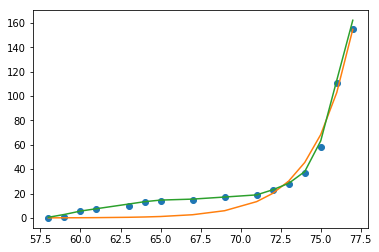

In [39]:
plt.plot(x,y,'o')
plt.plot(x, y_pred)
# plt.plot(x, y_reg)
plt.plot(x, y_pred_cnn)

In [40]:
from sklearn.neural_network import MLPRegressor
x_reg = x_norm.reshape(-1,1)
mlp = MLPRegressor(hidden_layer_sizes=(10,20,10), 
                   tol=1e-4, 
                   max_iter=10000,
                   solver='adam',
                   random_state=0,
                   verbose=1)
mlp.fit(x_reg, y_)

Iteration 1, loss = 1374.81020789
Iteration 2, loss = 1373.95719448
Iteration 3, loss = 1373.09854737
Iteration 4, loss = 1372.23669719
Iteration 5, loss = 1371.37144233
Iteration 6, loss = 1370.49439654
Iteration 7, loss = 1369.61374433
Iteration 8, loss = 1368.72876024
Iteration 9, loss = 1367.83020755
Iteration 10, loss = 1366.92173807
Iteration 11, loss = 1366.00500599
Iteration 12, loss = 1365.06117989
Iteration 13, loss = 1364.11149122
Iteration 14, loss = 1363.12777986
Iteration 15, loss = 1362.11786461
Iteration 16, loss = 1361.06683821
Iteration 17, loss = 1359.97019536
Iteration 18, loss = 1358.86310274
Iteration 19, loss = 1357.74496647
Iteration 20, loss = 1356.61145791
Iteration 21, loss = 1355.46503222
Iteration 22, loss = 1354.30862762
Iteration 23, loss = 1353.14198736
Iteration 24, loss = 1351.96498098
Iteration 25, loss = 1350.77746021
Iteration 26, loss = 1349.58023520
Iteration 27, loss = 1348.37336980
Iteration 28, loss = 1347.14518862
Iteration 29, loss = 1345.900

Iteration 430, loss = 335.87241951
Iteration 431, loss = 335.43125354
Iteration 432, loss = 335.02999529
Iteration 433, loss = 334.62816174
Iteration 434, loss = 334.22493357
Iteration 435, loss = 333.82093128
Iteration 436, loss = 333.41764112
Iteration 437, loss = 333.01601160
Iteration 438, loss = 332.62621008
Iteration 439, loss = 332.23313423
Iteration 440, loss = 331.84793414
Iteration 441, loss = 331.47181051
Iteration 442, loss = 331.09547545
Iteration 443, loss = 330.71906576
Iteration 444, loss = 330.34271489
Iteration 445, loss = 329.96655144
Iteration 446, loss = 329.59069795
Iteration 447, loss = 329.21526989
Iteration 448, loss = 328.84037494
Iteration 449, loss = 328.47422256
Iteration 450, loss = 328.10270677
Iteration 451, loss = 327.73900971
Iteration 452, loss = 327.37462165
Iteration 453, loss = 327.01007825
Iteration 454, loss = 326.64550416
Iteration 455, loss = 326.28101866
Iteration 456, loss = 325.91673465
Iteration 457, loss = 325.55275790
Iteration 458, loss 

Iteration 933, loss = 164.24015986
Iteration 934, loss = 163.80791550
Iteration 935, loss = 163.38020885
Iteration 936, loss = 162.96262797
Iteration 937, loss = 162.54589250
Iteration 938, loss = 162.14566900
Iteration 939, loss = 161.73890760
Iteration 940, loss = 161.32708605
Iteration 941, loss = 160.91140414
Iteration 942, loss = 160.50352326
Iteration 943, loss = 160.09943870
Iteration 944, loss = 159.69466304
Iteration 945, loss = 159.28923760
Iteration 946, loss = 158.88320101
Iteration 947, loss = 158.47658910
Iteration 948, loss = 158.06943510
Iteration 949, loss = 157.66176975
Iteration 950, loss = 157.25362164
Iteration 951, loss = 156.85650409
Iteration 952, loss = 156.45625970
Iteration 953, loss = 156.04955444
Iteration 954, loss = 155.63691332
Iteration 955, loss = 155.22106132
Iteration 956, loss = 154.81606006
Iteration 957, loss = 154.40996280
Iteration 958, loss = 154.00225077
Iteration 959, loss = 153.59306773
Iteration 960, loss = 153.18254733
Iteration 961, loss 

Iteration 1338, loss = 42.20298531
Iteration 1339, loss = 42.03703643
Iteration 1340, loss = 41.87145170
Iteration 1341, loss = 41.70623051
Iteration 1342, loss = 41.54137080
Iteration 1343, loss = 41.37686940
Iteration 1344, loss = 41.21272246
Iteration 1345, loss = 41.04892599
Iteration 1346, loss = 40.88547640
Iteration 1347, loss = 40.72237092
Iteration 1348, loss = 40.55960785
Iteration 1349, loss = 40.39718664
Iteration 1350, loss = 40.23510789
Iteration 1351, loss = 40.07337312
Iteration 1352, loss = 39.91198450
Iteration 1353, loss = 39.75094462
Iteration 1354, loss = 39.59025618
Iteration 1355, loss = 39.42992177
Iteration 1356, loss = 39.26994377
Iteration 1357, loss = 39.11032421
Iteration 1358, loss = 38.95106488
Iteration 1359, loss = 38.79216731
Iteration 1360, loss = 38.63363292
Iteration 1361, loss = 38.47546309
Iteration 1362, loss = 38.31765932
Iteration 1363, loss = 38.16022323
Iteration 1364, loss = 38.00315668
Iteration 1365, loss = 37.84646170
Iteration 1366, loss

Iteration 1616, loss = 14.16807772
Iteration 1617, loss = 14.11781405
Iteration 1618, loss = 14.06768272
Iteration 1619, loss = 14.01771359
Iteration 1620, loss = 13.96786140
Iteration 1621, loss = 13.91812753
Iteration 1622, loss = 13.86851325
Iteration 1623, loss = 13.81908321
Iteration 1624, loss = 13.76975895
Iteration 1625, loss = 13.72053365
Iteration 1626, loss = 13.67143962
Iteration 1627, loss = 13.62251069
Iteration 1628, loss = 13.57369918
Iteration 1629, loss = 13.52500627
Iteration 1630, loss = 13.47643548
Iteration 1631, loss = 13.42801274
Iteration 1632, loss = 13.37973789
Iteration 1633, loss = 13.33233683
Iteration 1634, loss = 13.28562688
Iteration 1635, loss = 13.23906906
Iteration 1636, loss = 13.19270666
Iteration 1637, loss = 13.14655970
Iteration 1638, loss = 13.10059890
Iteration 1639, loss = 13.05488213
Iteration 1640, loss = 13.00934184
Iteration 1641, loss = 12.96395252
Iteration 1642, loss = 12.91869109
Iteration 1643, loss = 12.87358984
Iteration 1644, loss

Iteration 2033, loss = 2.61771561
Iteration 2034, loss = 2.60782404
Iteration 2035, loss = 2.59798567
Iteration 2036, loss = 2.58819032
Iteration 2037, loss = 2.57844789
Iteration 2038, loss = 2.56875006
Iteration 2039, loss = 2.55911626
Iteration 2040, loss = 2.54953865
Iteration 2041, loss = 2.54054381
Iteration 2042, loss = 2.53134476
Iteration 2043, loss = 2.52190076
Iteration 2044, loss = 2.51233784
Iteration 2045, loss = 2.50330405
Iteration 2046, loss = 2.49440224
Iteration 2047, loss = 2.48545930
Iteration 2048, loss = 2.47645636
Iteration 2049, loss = 2.46740381
Iteration 2050, loss = 2.45841977
Iteration 2051, loss = 2.44946143
Iteration 2052, loss = 2.44050129
Iteration 2053, loss = 2.43198989
Iteration 2054, loss = 2.42341402
Iteration 2055, loss = 2.41463447
Iteration 2056, loss = 2.40576029
Iteration 2057, loss = 2.39722997
Iteration 2058, loss = 2.38887059
Iteration 2059, loss = 2.38046395
Iteration 2060, loss = 2.37200312
Iteration 2061, loss = 2.36349971
Iteration 2062

Iteration 2462, loss = 1.07200274
Iteration 2463, loss = 1.07102467
Iteration 2464, loss = 1.06997026
Iteration 2465, loss = 1.06892686
Iteration 2466, loss = 1.06794969
Iteration 2467, loss = 1.06698042
Iteration 2468, loss = 1.06598368
Iteration 2469, loss = 1.06495622
Iteration 2470, loss = 1.06394534
Iteration 2471, loss = 1.06293405
Iteration 2472, loss = 1.06188606
Iteration 2473, loss = 1.06089091
Iteration 2474, loss = 1.05988980
Iteration 2475, loss = 1.05889921
Iteration 2476, loss = 1.05793256
Iteration 2477, loss = 1.05692691
Iteration 2478, loss = 1.05593504
Iteration 2479, loss = 1.05499037
Iteration 2480, loss = 1.05401660
Iteration 2481, loss = 1.05302433
Iteration 2482, loss = 1.05207422
Iteration 2483, loss = 1.05112734
Iteration 2484, loss = 1.05015049
Iteration 2485, loss = 1.04918661
Iteration 2486, loss = 1.04827287
Iteration 2487, loss = 1.04732123
Iteration 2488, loss = 1.04632648
Iteration 2489, loss = 1.04538407
Iteration 2490, loss = 1.04448483
Iteration 2491

Iteration 2703, loss = 0.86311346
Iteration 2704, loss = 0.86262521
Iteration 2705, loss = 0.86212107
Iteration 2706, loss = 0.86159460
Iteration 2707, loss = 0.86104569
Iteration 2708, loss = 0.86069765
Iteration 2709, loss = 0.86015457
Iteration 2710, loss = 0.85951106
Iteration 2711, loss = 0.85902768
Iteration 2712, loss = 0.85851748
Iteration 2713, loss = 0.85798965
Iteration 2714, loss = 0.85752897
Iteration 2715, loss = 0.85700527
Iteration 2716, loss = 0.85664782
Iteration 2717, loss = 0.85607784
Iteration 2718, loss = 0.85546097
Iteration 2719, loss = 0.85501184
Iteration 2720, loss = 0.85453683
Iteration 2721, loss = 0.85403804
Iteration 2722, loss = 0.85351768
Iteration 2723, loss = 0.85297812
Iteration 2724, loss = 0.85260765
Iteration 2725, loss = 0.85208981
Iteration 2726, loss = 0.85153189
Iteration 2727, loss = 0.85109287
Iteration 2728, loss = 0.85062577
Iteration 2729, loss = 0.85013258
Iteration 2730, loss = 0.84961614
Iteration 2731, loss = 0.84908388
Iteration 2732

Iteration 2999, loss = 0.74414925
Iteration 3000, loss = 0.74377231
Iteration 3001, loss = 0.74347940
Iteration 3002, loss = 0.74320186
Iteration 3003, loss = 0.74290244
Iteration 3004, loss = 0.74258903
Iteration 3005, loss = 0.74226252
Iteration 3006, loss = 0.74192170
Iteration 3007, loss = 0.74156779
Iteration 3008, loss = 0.74135036
Iteration 3009, loss = 0.74106017
Iteration 3010, loss = 0.74071332
Iteration 3011, loss = 0.74031825
Iteration 3012, loss = 0.74007493
Iteration 3013, loss = 0.73981614
Iteration 3014, loss = 0.73953445
Iteration 3015, loss = 0.73923324
Iteration 3016, loss = 0.73890925
Iteration 3017, loss = 0.73857760
Iteration 3018, loss = 0.73823556
Iteration 3019, loss = 0.73789813
Iteration 3020, loss = 0.73759780
Iteration 3021, loss = 0.73733725
Iteration 3022, loss = 0.73701043
Iteration 3023, loss = 0.73664661
Iteration 3024, loss = 0.73636280
Iteration 3025, loss = 0.73606329
Iteration 3026, loss = 0.73574652
Iteration 3027, loss = 0.73541322
Iteration 3028

Iteration 3256, loss = 0.67739131
Iteration 3257, loss = 0.67719124
Iteration 3258, loss = 0.67696668
Iteration 3259, loss = 0.67677753
Iteration 3260, loss = 0.67657659
Iteration 3261, loss = 0.67637053
Iteration 3262, loss = 0.67615328
Iteration 3263, loss = 0.67594968
Iteration 3264, loss = 0.67575105
Iteration 3265, loss = 0.67552628
Iteration 3266, loss = 0.67534149
Iteration 3267, loss = 0.67514893
Iteration 3268, loss = 0.67494607
Iteration 3269, loss = 0.67473009
Iteration 3270, loss = 0.67450304
Iteration 3271, loss = 0.67433040
Iteration 3272, loss = 0.67414444
Iteration 3273, loss = 0.67393569
Iteration 3274, loss = 0.67370590
Iteration 3275, loss = 0.67350889
Iteration 3276, loss = 0.67333800
Iteration 3277, loss = 0.67313074
Iteration 3278, loss = 0.67292169
Iteration 3279, loss = 0.67270242
Iteration 3280, loss = 0.67250110
Iteration 3281, loss = 0.67231831
Iteration 3282, loss = 0.67210601
Iteration 3283, loss = 0.67189781
Iteration 3284, loss = 0.67170797
Iteration 3285

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [41]:
y_new_pred = mlp.predict(x_reg)
y_new_pred

array([  0.41137997,   2.43040698,   4.449434  ,   6.46846101,
        10.50651505,  12.52554206,  13.49000449,  15.41282045,
        17.31482333,  19.1776025 ,  23.30710783,  27.43661316,
        37.07972453,  59.44562937, 107.99776496, 156.54990055])

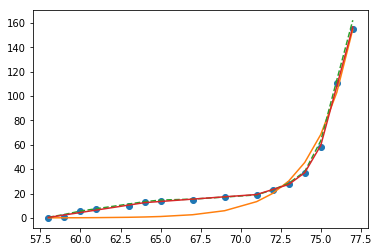

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')
# ax.plot(x, y_reg, '-')
ax.plot(x, y_pred_cnn, '--')
ax.plot(x, y_new_pred, '-')

In [43]:
x_Day = np.array([100])
x_Day = x_Day.reshape(1,-1)
y_day = mlp.predict(x_Day)
y_day

array([20355.35552838])